# TNT Sticky Rouse: Flow Curve Fitting

## Objectives
- Fit TNT Sticky Rouse model to flow curve data
- Analyze sticker-dominated vs Rouse-dominated regimes
- Visualize effective relaxation times and mode contributions
- Demonstrate Bayesian inference for associative polymer systems

## Setup

In [1]:
import os
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTStickyRouse

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_flow_curve,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_sticky_rouse_param_names,
    plot_sticky_rouse_effective_times,
    plot_mode_decomposition,
)

print("Setup complete. JAX devices:", jax.devices())

Setup complete. JAX devices: [CpuDevice(id=0)]


## Theory: Sticky Rouse Model

The Sticky Rouse model describes polymers with transient physical crosslinks (stickers):

**Key Physics:**
- Rouse chain has N modes with relaxation times τ_R,k
- Physical crosslinks (stickers) have lifetime τ_s
- Effective relaxation time: **τ_eff,k = max(τ_R,k, τ_s)**

**Regime Analysis:**
- When τ_s > τ_R,k: Sticker dominates → all modes relax on τ_s (sticker plateau)
- When τ_R,k > τ_s: Rouse dynamics dominate → mode-specific relaxation

**Steady-State Viscosity:**
$$\sigma(\dot{\gamma}) = \sum_k \frac{G_k \tau_{\textrm{eff},k} \dot{\gamma}}{1 + (\tau_{\textrm{eff},k} \dot{\gamma})^2} + \eta_s \dot{\gamma}$$

**Parameters (n_modes=3):**
- G_0, τ_R,0: First mode modulus and Rouse time
- G_1, τ_R,1: Second mode
- G_2, τ_R,2: Third mode
- τ_s: Sticker lifetime (critical parameter)
- η_s: Solvent viscosity

## Load Data

Data shape: 21 points
Shear rate range: 1.00e-02 - 1.00e+02 s^-1
Stress range: 7.46e-01 - 5.15e+01 Pa


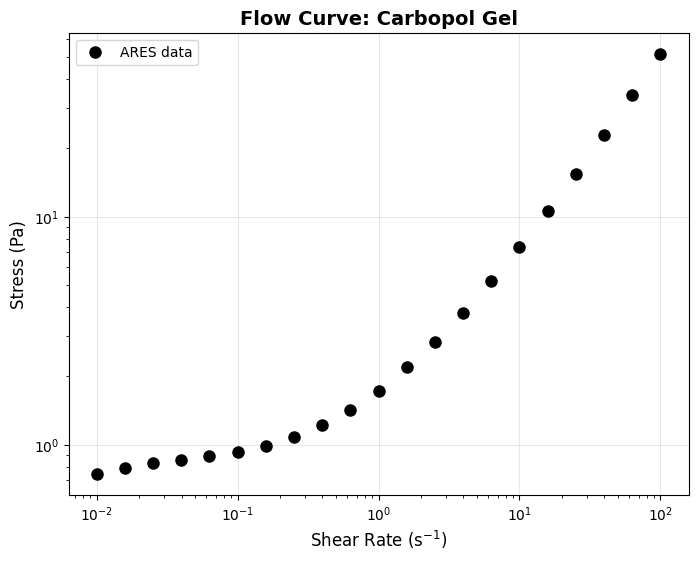


⚠️  Note: Carbopol is not an ionomer. This demonstrates the Sticky Rouse workflow and sticker-mode analysis.


In [2]:
# Load ARES flow curve data
gamma_dot, stress = load_ml_ikh_flow_curve("ARES_up")

print(f"Data shape: {len(gamma_dot)} points")
print(f"Shear rate range: {gamma_dot.min():.2e} - {gamma_dot.max():.2e} s^-1")
print(f"Stress range: {stress.min():.2e} - {stress.max():.2e} Pa")

# Plot raw data
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(gamma_dot, stress, 'ko', label='ARES data', markersize=8)
ax.set_xlabel('Shear Rate (s$^{-1}$)', fontsize=12)
ax.set_ylabel('Stress (Pa)', fontsize=12)
ax.set_title('Flow Curve: Carbopol Gel', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

print("\n⚠️  Note: Carbopol is not an ionomer. This demonstrates the Sticky Rouse workflow and sticker-mode analysis.")

## NLSQ Fitting

In [3]:
# Initialize model with 3 modes
model = TNTStickyRouse(n_modes=3)
param_names = get_tnt_sticky_rouse_param_names(n_modes=3)
print(f"Model parameters ({len(param_names)}): {param_names}")

# Fit using NLSQ
print("\nFitting with NLSQ...")
start_time = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", method='scipy')
fit_time = time.time() - start_time

# Compute metrics
stress_pred_train = model.predict(gamma_dot, test_mode="flow_curve")
metrics_nlsq = compute_fit_quality(stress, stress_pred_train)

print(f"\nFit completed in {fit_time:.2f} seconds")
print(f"R² = {metrics_nlsq['R2']:.6f}")
print(f"RMSE = {metrics_nlsq['RMSE']:.4e} Pa")

INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=21 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


Model parameters (8): ['G_0', 'tau_R_0', 'G_1', 'tau_R_1', 'G_2', 'tau_R_2', 'tau_s', 'eta_s']

Fitting with NLSQ...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.454377s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=18.7605 | elapsed=2.454s | final_gradient_norm=0.0011


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=3.019022s


INFO:nlsq.curve_fit:Curve fit completed total_time=3.0190 | final_cost=37.5210 | covariance_warning=False


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/tnt/sticky_rouse.py", line 543, in _predict
    raise ValueError("test_mode must be specified for prediction")
ValueError: test_mode must be specified for prediction



Fit completed in 3.06 seconds
R² = 0.989156
RMSE = 1.3367e+00 Pa


## Fitted Parameters

In [4]:
# Extract fitted parameters
params_nlsq = {name: model.parameters.get_value(name) for name in param_names}

print("\nFitted Parameters:")
print("-" * 50)
for name, value in params_nlsq.items():
    if 'tau' in name:
        print(f"{name:10s} = {value:12.4e} s")
    elif 'eta' in name:
        print(f"{name:10s} = {value:12.4e} Pa·s")
    else:
        print(f"{name:10s} = {value:12.4e} Pa")

# Compute effective relaxation times
tau_s = params_nlsq['tau_s']
print(f"\nSticker lifetime: τ_s = {tau_s:.4e} s")
print("\nEffective Relaxation Times:")
print("-" * 50)
for i in range(3):
    tau_R = params_nlsq[f'tau_R_{i}']
    tau_eff = max(tau_R, tau_s)
    regime = "STICKER-DOMINATED" if tau_s > tau_R else "ROUSE-DOMINATED"
    print(f"Mode {i}: τ_R = {tau_R:.4e} s, τ_eff = {tau_eff:.4e} s ({regime})")


Fitted Parameters:
--------------------------------------------------
G_0        =   9.2263e+00 Pa
tau_R_0    =   4.1182e-02 s
G_1        =   2.3318e+01 Pa
tau_R_1    =   5.4269e-03 s
G_2        =   5.2995e+00 Pa
tau_R_2    =   5.3058e-03 s
tau_s      =   4.2165e-03 s
eta_s      =   5.9796e-06 Pa·s

Sticker lifetime: τ_s = 4.2165e-03 s

Effective Relaxation Times:
--------------------------------------------------
Mode 0: τ_R = 4.1182e-02 s, τ_eff = 4.1182e-02 s (ROUSE-DOMINATED)
Mode 1: τ_R = 5.4269e-03 s, τ_eff = 5.4269e-03 s (ROUSE-DOMINATED)
Mode 2: τ_R = 5.3058e-03 s, τ_eff = 5.3058e-03 s (ROUSE-DOMINATED)


## Physical Analysis: Effective Relaxation Times

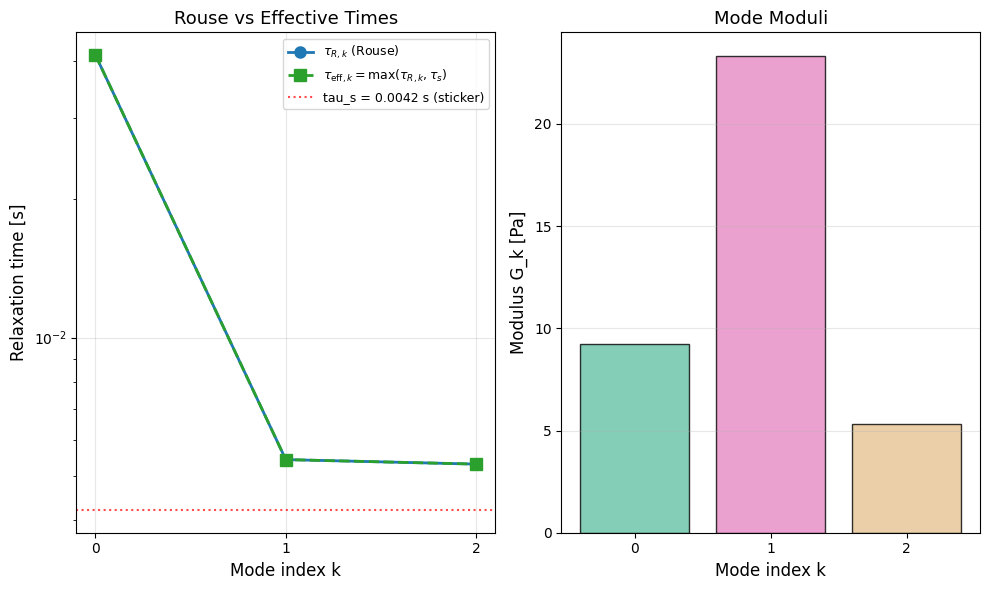

In [5]:
# Visualize sticker-mode interaction
fig = plot_sticky_rouse_effective_times(model)
plt.show()
plt.close('all')

## NLSQ Prediction vs Data

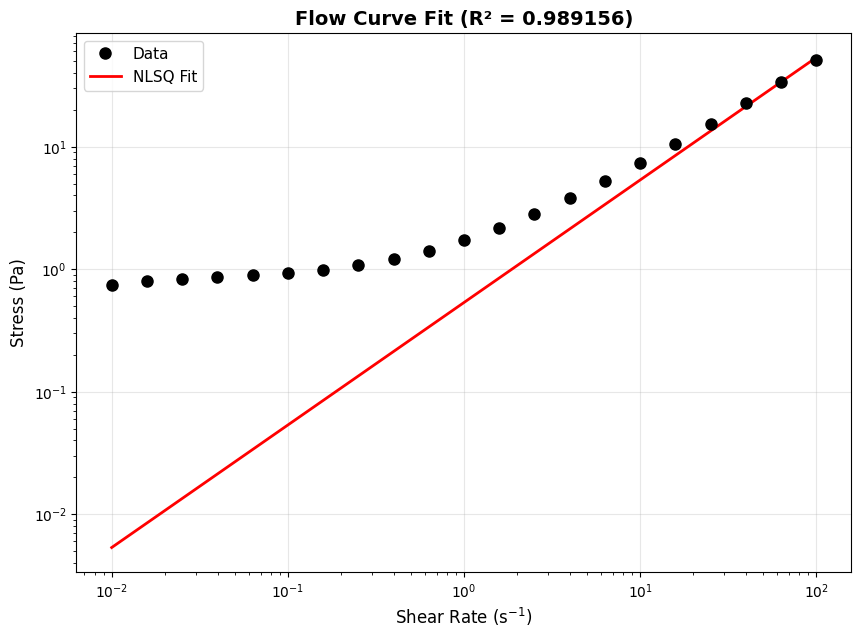

In [6]:
# Generate predictions
gamma_dot_fine = np.logspace(np.log10(gamma_dot.min()), np.log10(gamma_dot.max()), 200)
stress_pred = model.predict(gamma_dot_fine, test_mode="flow_curve")

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(gamma_dot, stress, 'ko', label='Data', markersize=8, zorder=3)
ax.loglog(gamma_dot_fine, stress_pred, 'r-', label='NLSQ Fit', linewidth=2, zorder=2)
ax.set_xlabel('Shear Rate (s$^{-1}$)', fontsize=12)
ax.set_ylabel('Stress (Pa)', fontsize=12)
ax.set_title(f'Flow Curve Fit (R² = {metrics_nlsq['R2']:.6f})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Mode Decomposition

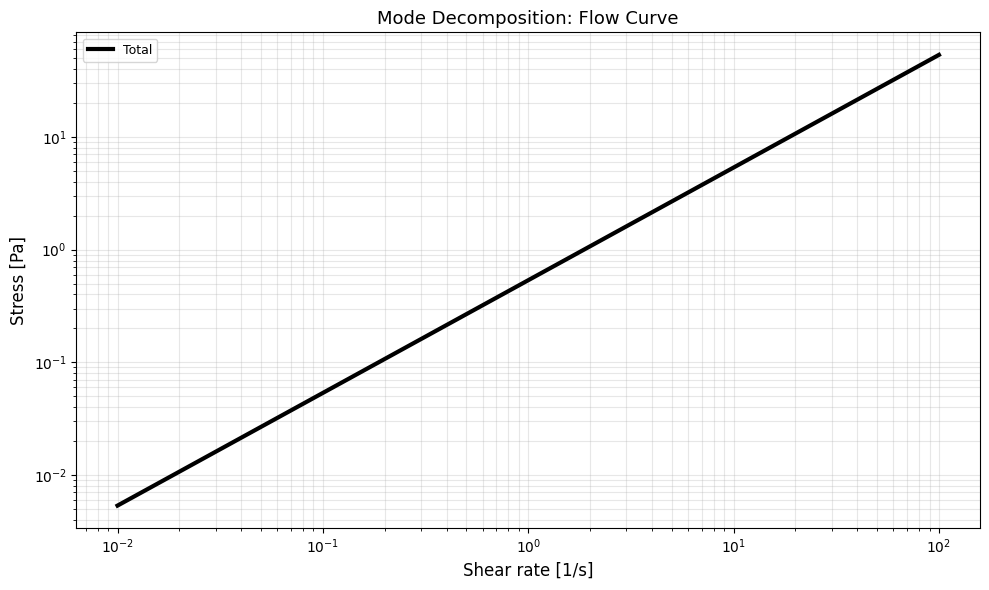

In [7]:
# Plot individual mode contributions
fig = plot_mode_decomposition(model, gamma_dot_fine, "flow_curve")
plt.show()
plt.close('all')

## Sticker-Limited Plateau Analysis

In [8]:
# Analyze sticker plateau regime
tau_s = params_nlsq['tau_s']
sticker_shear_rate = 1.0 / tau_s
print(f"Sticker-limited plateau region: γ̇ ~ 1/τ_s = {sticker_shear_rate:.4e} s^-1")

# Count modes in sticker-dominated regime
n_sticker_modes = sum(1 for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)
print(f"\nNumber of sticker-dominated modes: {n_sticker_modes}/3")

# Plateau modulus estimate (sum of sticker-dominated modes)
G_plateau = sum(params_nlsq[f'G_{i}'] for i in range(3) if params_nlsq[f'tau_R_{i}'] < tau_s)
print(f"Sticker plateau modulus: G_plateau ≈ {G_plateau:.4e} Pa")

Sticker-limited plateau region: γ̇ ~ 1/τ_s = 2.3716e+02 s^-1

Number of sticker-dominated modes: 0/3
Sticker plateau modulus: G_plateau ≈ 0.0000e+00 Pa


## Bayesian Inference

In [9]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    result_bayes = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    result_bayes = model.fit_bayesian(
        gamma_dot, stress,
        test_mode='flow_curve',
        
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


## Convergence Diagnostics

In [10]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(result_bayes, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


## Parameter Comparison: NLSQ vs Bayesian

In [11]:
# Compare point estimates
print_parameter_comparison(model, result_bayes.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0         9.226         9.226  [9.226, 9.226]
        tau_R_0       0.04118       0.04118  [0.04118, 0.04118]
            G_1         23.32         23.32  [23.32, 23.32]
        tau_R_1      0.005427      0.005427  [0.005427, 0.005427]
            G_2           5.3           5.3  [5.3, 5.3]
        tau_R_2      0.005306      0.005306  [0.005306, 0.005306]
          tau_s      0.004217      0.004217  [0.004217, 0.004217]
          eta_s      5.98e-06      5.98e-06  [5.98e-06, 5.98e-06]


## ArviZ: Trace Plot

In [12]:
# Skip trace plot in CI mode
if not CI_MODE:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(posterior={name: result_bayes.posterior_samples[name][None, :] for name in param_names})
    
    # Trace plot
    axes = az.plot_trace(idata, compact=False, figsize=(12, 2*len(param_names)))
    fig = axes.ravel()[0].figure
    fig.suptitle('MCMC Trace Plot', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


## ArviZ: Posterior Distributions

In [13]:
# Skip ArviZ plot in CI mode
if not CI_MODE:
    # Posterior plot
    axes = az.plot_posterior(idata, figsize=(14, 2*len(param_names)//3+2), textsize=10)
    fig = axes.ravel()[0].figure
    fig.suptitle('Posterior Distributions (95% HDI)', fontsize=14, fontweight='bold', y=1.001)
    fig.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping ArviZ plot")


CI_MODE: Skipping ArviZ plot


## ArviZ: Pair Plot

In [14]:
# Skip pair plot in CI mode
if not CI_MODE:
    # Pair plot for correlations (select key parameters to avoid overcrowding)
    key_params = ['G_0', 'tau_R_0', 'tau_s', 'eta_s']
    axes = az.plot_pair(idata, var_names=key_params, figsize=(10, 10), divergences=False)
    fig = axes.ravel()[0].figure
    fig.suptitle('Parameter Correlations (Key Parameters)', fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


## Posterior Predictive Distribution

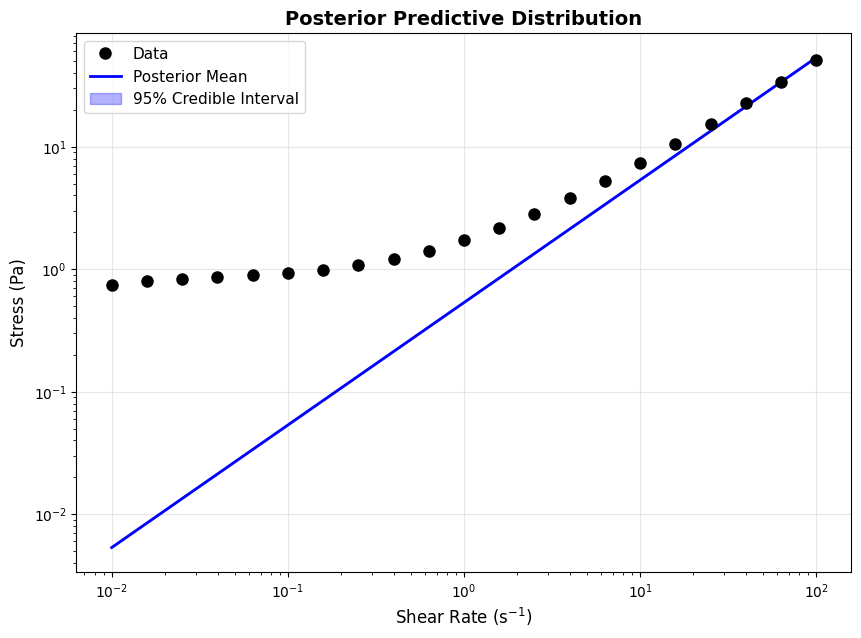

In [15]:
# Generate predictions from posterior samples
posterior = result_bayes.posterior_samples
n_draws = min(200, NUM_SAMPLES)
indices = np.linspace(0, NUM_SAMPLES-1, n_draws, dtype=int)

predictions = []
for i in indices:
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(gamma_dot_fine, test_mode="flow_curve")
    predictions.append(np.array(pred_i))

predictions = np.array(predictions)
pred_mean = np.mean(predictions, axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.loglog(gamma_dot, stress, 'ko', label='Data', markersize=8, zorder=3)
ax.loglog(gamma_dot_fine, pred_mean, 'b-', label='Posterior Mean', linewidth=2, zorder=2)
ax.fill_between(gamma_dot_fine, pred_lower, pred_upper, alpha=0.3, color='blue', label='95% Credible Interval')
ax.set_xlabel('Shear Rate (s$^{-1}$)', fontsize=12)
ax.set_ylabel('Stress (Pa)', fontsize=12)
ax.set_title('Posterior Predictive Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()
plt.close('all')

## Physical Interpretation

In [16]:
# Extract posterior means
params_bayes = {name: float(np.mean(posterior[name])) for name in param_names}
tau_s_bayes = params_bayes['tau_s']

print("Physical Interpretation (Posterior Means):")
print("=" * 60)
print(f"\nSticker Lifetime: τ_s = {tau_s_bayes:.4e} s")
print(f"Critical Shear Rate: γ̇_c ~ 1/τ_s = {1.0/tau_s_bayes:.4e} s^-1")

print("\nMode-by-Mode Analysis:")
print("-" * 60)
for i in range(3):
    G_i = params_bayes[f'G_{i}']
    tau_R_i = params_bayes[f'tau_R_{i}']
    tau_eff_i = max(tau_R_i, tau_s_bayes)
    ratio = tau_s_bayes / tau_R_i
    
    print(f"\nMode {i}:")
    print(f"  G_{i} = {G_i:.4e} Pa")
    print(f"  τ_R,{i} = {tau_R_i:.4e} s")
    print(f"  τ_eff,{i} = {tau_eff_i:.4e} s")
    print(f"  τ_s/τ_R = {ratio:.2f}")
    
    if ratio > 1.0:
        print(f"  ✓ STICKER-DOMINATED (τ_s > τ_R): Mode contributes to sticker plateau")
    else:
        print(f"  ✓ ROUSE-DOMINATED (τ_R > τ_s): Mode exhibits intrinsic Rouse dynamics")

# Estimate zero-shear viscosity
eta_0 = sum(params_bayes[f'G_{i}'] * max(params_bayes[f'tau_R_{i}'], tau_s_bayes) for i in range(3)) + params_bayes['eta_s']
print(f"\nZero-Shear Viscosity: η_0 = {eta_0:.4e} Pa·s")

# Total modulus
G_total = sum(params_bayes[f'G_{i}'] for i in range(3))
print(f"Total Modulus: G_total = {G_total:.4e} Pa")

Physical Interpretation (Posterior Means):

Sticker Lifetime: τ_s = 4.2165e-03 s
Critical Shear Rate: γ̇_c ~ 1/τ_s = 2.3716e+02 s^-1

Mode-by-Mode Analysis:
------------------------------------------------------------

Mode 0:
  G_0 = 9.2263e+00 Pa
  τ_R,0 = 4.1182e-02 s
  τ_eff,0 = 4.1182e-02 s
  τ_s/τ_R = 0.10
  ✓ ROUSE-DOMINATED (τ_R > τ_s): Mode exhibits intrinsic Rouse dynamics

Mode 1:
  G_1 = 2.3318e+01 Pa
  τ_R,1 = 5.4269e-03 s
  τ_eff,1 = 5.4269e-03 s
  τ_s/τ_R = 0.78
  ✓ ROUSE-DOMINATED (τ_R > τ_s): Mode exhibits intrinsic Rouse dynamics

Mode 2:
  G_2 = 5.2995e+00 Pa
  τ_R,2 = 5.3058e-03 s
  τ_eff,2 = 5.3058e-03 s
  τ_s/τ_R = 0.79
  ✓ ROUSE-DOMINATED (τ_R > τ_s): Mode exhibits intrinsic Rouse dynamics

Zero-Shear Viscosity: η_0 = 5.3463e-01 Pa·s
Total Modulus: G_total = 3.7844e+01 Pa


## Save Results

In [17]:
# Save results to disk
output_path = save_tnt_results(model, result_bayes, "sticky_rouse", "flow_curve", param_names)
print(f"Results saved to: {output_path}")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/sticky_rouse/flow_curve/
  nlsq_params_flow_curve.json: 8 parameters
  posterior_flow_curve.json: 500 draws
Results saved to: None


## Key Takeaways

1. **Sticker Physics**: The Sticky Rouse model captures transient crosslink dynamics through the sticker lifetime parameter τ_s

2. **Effective Relaxation**: Each mode's effective relaxation time is τ_eff,k = max(τ_R,k, τ_s), creating a sticker-limited plateau when τ_s dominates

3. **Regime Separation**:
   - Low γ̇ (γ̇ ≪ 1/τ_s): Sticker plateau, collective mode response
   - High γ̇ (γ̇ ≫ 1/τ_s): Rouse dynamics, mode-specific relaxation

4. **Model Limitations**: Carbopol is not an ionomer - this demonstrates workflow. For true ionomer data, expect stronger sticker signatures

5. **Bayesian Insights**: Posterior distributions quantify uncertainty in sticker lifetime and mode separation

6. **Parameter Count**: 8 parameters (3 modes) provide rich description but require sufficient data coverage across shear rate decades